In [1]:
using CSV, DataFrames
using PyPlot, LaTeXStrings, PyCall
using Interpolations, Distributions, Dierckx

@pyimport numpy as np
@pyimport scienceplots

In [2]:
# 船体に働く流体力
function X_H(u, v, r)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    return 0.5 * ρ * L_pp * d * (U^2) * X_H_dash(v_dash, r_dash)
end

function Y_H(u, v, r)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    return 0.5 * ρ * L_pp * d * (U^2) * Y_H_dash(v_dash, r_dash)
end

function N_H(u, v, r)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    return 0.5 * ρ * (L_pp^2) * d * (U^2) * N_H_dash(v_dash, r_dash)
end

# 船体に働く流体力(無次元)
function X_H_dash(v_dash, r_dash)
    return -R_0_dash + X_vv_dash*(v_dash)^2 + X_vr_dash*v_dash*r_dash + X_rr_dash*(r_dash^2) + X_vvvv_dash*(v_dash^4)
end

function Y_H_dash(v_dash, r_dash)
    return Y_v_dash*v_dash + Y_r_dash*r_dash + Y_vvr_dash*(v_dash)^2*r_dash + Y_vrr_dash*v_dash*r_dash^2 + Y_vvv_dash*(v_dash^3) + Y_rrr_dash*r_dash^3
end

function N_H_dash(v_dash, r_dash)
    return N_v_dash*v_dash + N_r_dash*r_dash + N_vvr_dash*(v_dash^2)*r_dash + N_vrr_dash*v_dash*r_dash^2 + N_vvv_dash*(v_dash^3) + N_rrr_dash*r_dash^3
end

# 舵に働く力
function X_R(u, v, r, δ, n_p)
    return -(1 - t_R) * F_N(u, v, r, δ, n_p) * sin(δ)
end

function Y_R(u, v, r, δ, n_p)
    return -(1 + a_H) * F_N(u, v, r, δ, n_p) * cos(δ)
end

function N_R(u, v, r, δ, n_p)
    return -(x_R + a_H * x_H) * F_N(u, v, r, δ, n_p) * cos(δ)
end

function F_N(u, v, r, δ, n_p)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    w_P = w_P0 * exp(-4.0 * (β - x_P * r_dash)^2)
    u_p = (1 - w_P) * u
    if J(u, v, r, n_p) == 0.0
        u_R = sqrt(η * (κ * ϵ * 8.0 * k_0 * n_p^2 * D_p^4 / pi)^2)
    else
        u_R = u * (1.0 - w_P) * ϵ * sqrt(η * (1.0 + κ * (sqrt(1.0 + 8.0 * K_T(u, v, r, n_p) / (pi * J(u, v, r, n_p)^2)) - 1))^2 + (1 - η))
    end
    β_R = β - l_R * r_dash
    if β_R < 0.0
        γ_R = γ_R_minus
    else
        γ_R = γ_R_plus
    end 
    v_R = U * γ_R * β_R
    α_R = δ - atan(v_R, u_R)
    U_R = sqrt(u_R^2 + v_R^2)
    return 0.5 * ρ * A_R * (U_R^2) * f_α * sin(α_R)
end

# プロペラに働く力
function X_P(u, v, r, δ, n_p)
    return (1 - t_P) * T_P(u, v, r, n_p)
end

function K_T(u, v, r, n_p)
    return k_0 + k_1 * J(u, v, r, n_p) + k_2 * (J(u, v, r, n_p)^2)
end

function J(u, v, r, n_p)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    w_P = w_P0 * exp(-4.0 * (β - x_P * r_dash)^2)
    return u * (1 - w_P) / (n_p * D_p)
end

function T_P(u, v, r, n_p)
    return K_T(u, v, r, n_p) * ρ * n_p^2 * D_p^4
end

function MMG(x_0, X_F, Y_F, N_F, δ, n_p)
    u = x_0[1] + dt * ((X_H(x_0[1], x_0[2], x_0[3]) + X_R(x_0[1], x_0[2], x_0[3], δ, n_p) + X_P(x_0[1], x_0[2], x_0[3], δ, n_p) + X_F + (m + m_y) * x_0[2] * x_0[3]) / (m + m_x))
    u = isfinite(u) ? u : 0.0
    v = x_0[2] + dt * ((Y_H(x_0[1], x_0[2], x_0[3]) + Y_R(x_0[1], x_0[2], x_0[3], δ, n_p) + Y_F - (m + m_x) * x_0[1] * x_0[3]) / (m + m_y))
    v = isfinite(v) ? v : 0.0
    r = x_0[3] + dt * ((N_H(x_0[1], x_0[2], x_0[3]) + N_R(x_0[1], x_0[2], x_0[3], δ, n_p) + N_F) / (I_zG + J_z))
    r = isfinite(r) ? r : 0.0
    x = x_0[6] + dt * (x_0[1] * cos(x_0[8]) - x_0[2] * sin(x_0[8]))
    x = isfinite(x) ? x : 0.0
    y = x_0[7] + dt * (x_0[1] * sin(x_0[8]) + x_0[2] * cos(x_0[8]))
    y = isfinite(y) ? y : 0.0
    ψ = x_0[8] + dt * (x_0[3])
    ψ = isfinite(ψ) ? ψ : 0.0
    x1 = x + L_f * cos(ψ)
    x1 = isfinite(x1) ? x1 : 0.0
    y1 = y + L_f * sin(ψ)
    y1 = isfinite(y1) ? y1 : 0.0
    x2 = x + L_t * cos(ψ + pi)
    x2 = isfinite(x2) ? x2 : 0.0
    y2 = y + L_t * sin(ψ + pi)
    y2 = isfinite(y2) ? y2 : 0.0
    return u, v, r, δ, n_p, x, y, ψ, x1, y1, x2, y2
end

ρ = 1025.0
L_pp = 7.00  # 船長Lpp[m]
B = 1.27  # 船幅[m]
d = 0.46  # 喫水[m]
nabla = 3.27  # 排水量[m^3]
x_G = 0.25  # 重心位置[m]
# C_b = 0.810  # 方形係数[-]
D_p = 0.216  # プロペラ直径[m]
H_R = 0.345  # 舵高さ[m]
A_R = 0.0539  # 舵断面積[m^2]
t_P = 0.220  # 推力減少率
w_P0 = 0.40  # 有効伴流率
m_x_dash = 0.022  # 付加質量x(無次元)
m_y_dash = 0.223  # 付加質量y(無次元)
J_z_dash = 0.011  # 付加質量Izz(無次元)
t_R = 0.387  # 操縦抵抗減少率
x_R_dash = -0.500  # 舵の相対位置
a_H = 0.312  # 舵力増加係数
x_H_dash = -0.464  # 舵力増分作用位置
γ_R_minus = 0.395  # 整流係数
γ_R_plus = 0.640  # 整流係数
l_r_dash = -0.710  # 船長に対する舵位置
x_P_dash = -0.690  # 船長に対するプロペラ位置
ϵ = 1.09  # プロペラ・舵位置伴流係数比
κ = 0.50  # 修正係数
f_α = 2.747  # 直圧力勾配係数

L_pp = L_pp  # 船長Lpp[m]
B = B  # 船幅[m]
d = d  # 喫水[m]
x_G = x_G  # 重心位置[]
D_p = D_p  # プロペラ直径[m]
m = ρ * nabla  # 質量(無次元化)[kg]
I_zG = ρ * nabla * ((0.25 * L_pp)^2)  # 慣性モーメント[-]
A_R = A_R  # 船の断面に対する舵面積比[-]
η = D_p / H_R  # プロペラ直径に対する舵高さ(Dp/H)
m_x = (0.5 * ρ * (L_pp^2) * d) * m_x_dash  # 付加質量x(無次元)
m_y = (0.5 * ρ * (L_pp^2) * d) * m_y_dash  # 付加質量y(無次元)
J_z = (0.5 * ρ * (L_pp^4) * d) * J_z_dash  # 付加質量Izz(無次元)
f_α = f_α # 直圧力勾配係数
ϵ = ϵ  # プロペラ・舵位置伴流係数比
t_R = t_R  # 操縦抵抗減少率
x_R = x_R_dash * L_pp  # 舵の位置
a_H = a_H  # 舵力増加係数
x_H = x_H_dash * L_pp  # 舵力増分作用位置
γ_R_minus = γ_R_minus  # 整流係数
γ_R_plus = γ_R_plus  # 整流係数
l_R = l_r_dash  # 船長に対する舵位置
κ = κ  # 修正係数
t_P = t_P  # 推力減少率
w_P0 = w_P0  # 有効伴流率
x_P = x_P_dash  # 船長に対するプロペラ位置

const k_0 = 0.2931
const k_1 = -0.2753
const k_2 = -0.1385

L_f = 3.0
L_t = 3.0

D = 0.6563 # 深さ[m]
A_OD = 0.65 # デッキ上の構造物の側面投影面積[m^2]
H_BR = 0.85 # 喫水からブリッジ主要構造物の最高位[m]
H_C = 0.235 # 喫水から側面積中心までの高さ[m]
C = 0.0 # 船体中心から側面積中心までの前後方向座標(船首方向を正)[m]


function MMG_p(i)
    global R_0_dash, X_vv_dash, X_vr_dash, X_rr_dash, X_vvvv_dash
    global Y_v_dash, Y_r_dash, Y_vvv_dash, Y_vvr_dash, Y_vrr_dash, Y_rrr_dash
    global N_v_dash, N_r_dash, N_vvv_dash, N_vvr_dash, N_vrr_dash, N_rrr_dash
    global x_0, δ_ref, n_p_ref, X_F, Y_F, N_F
    global p

    x_0 = x_1
    # データフレーム
    cols = Int(duration/dt) + 1
    df_x = DataFrame(
        time = collect(0:dt:duration),
        u = zeros(cols),
        v = zeros(cols),
        r = zeros(cols),
        δ = zeros(cols),
        n_p = zeros(cols),
        x = zeros(cols),
        y = zeros(cols),
        ψ = zeros(cols),
        x1 = zeros(cols),
        y1 = zeros(cols),
        x2 = zeros(cols),
        y2 = zeros(cols),
        X_F = zeros(cols),
        Y_F = zeros(cols),
        N_F = zeros(cols),
    )
    #初期値をデータフレームへ
    df_x[1, 2:13] .= x_0
    df_x[1, 14:16] .= [X_F0, Y_F0, N_F0]

    R_0_dash = p[i, 4]
    X_vv_dash = p[i, 5]
    X_vr_dash = p[i, 6]
    X_rr_dash = p[i, 7]
    X_vvvv_dash = p[i, 8]
    Y_v_dash = p[i, 9]
    Y_r_dash = p[i, 10]
    Y_vvv_dash = p[i, 11]
    Y_vvr_dash = p[i, 12]
    Y_vrr_dash = p[i, 13]
    Y_rrr_dash = p[i, 14]
    N_v_dash = p[i, 15]
    N_r_dash = p[i, 16]
    N_vvv_dash = p[i, 17]
    N_vvr_dash = p[i, 18]
    N_vrr_dash = p[i, 19]
    N_rrr_dash = p[i, 20]    

    for t in 1 : Int(duration/dt)
        U_W_t = U_W_list[t]
        Ψ_W_t = Ψ_W_list[t]
    
        x_F = X_F_list[t]
        y_F = Y_F_list[t]
        n_F = N_F_list[t] 
    
        x_val = MMG(x_0, x_F, y_F, n_F, δ_list[t], n_p_list[t])
        df_x[t+1, 2:13] .= x_val
        df_x[t+1, 14:16] .= [x_F, y_F, n_F]
        x_0 = collect(x_val) 
    end
    return df_x
end

function MMG_random(i)
    global R_0_dash, X_vv_dash, X_vr_dash, X_rr_dash, X_vvvv_dash
    global Y_v_dash, Y_r_dash, Y_vvv_dash, Y_vvr_dash, Y_vrr_dash, Y_rrr_dash
    global N_v_dash, N_r_dash, N_vvv_dash, N_vvr_dash, N_vrr_dash, N_rrr_dash
    global x_0, δ_ref, n_p_ref, X_F, Y_F, N_F
    global p

    x_0 = x_1
    # データフレーム
    cols = Int(duration/dt) + 1
    df_x2 = DataFrame(
        time = collect(0:dt:duration),
        u = zeros(cols),
        v = zeros(cols),
        r = zeros(cols),
        δ = zeros(cols),
        n_p = zeros(cols),
        x = zeros(cols),
        y = zeros(cols),
        ψ = zeros(cols),
        x1 = zeros(cols),
        y1 = zeros(cols),
        x2 = zeros(cols),
        y2 = zeros(cols),
        X_F = zeros(cols),
        Y_F = zeros(cols),
        N_F = zeros(cols),
    )
    #初期値をデータフレームへ
    df_x2[1, 2:13] .= x_0
    df_x2[1, 14:16] .= [X_F0, Y_F0, N_F0]   

    for t in 1 : Int(duration/dt)
        random_num = rand(500:1000)
        R_0_dash = p[random_num, 4]
        X_vv_dash = p[random_num, 5]
        X_vr_dash = p[random_num, 6]
        X_rr_dash = p[random_num, 7]
        X_vvvv_dash = p[random_num, 8]
        Y_v_dash = p[random_num, 9]
        Y_r_dash = p[random_num, 10]
        Y_vvv_dash = p[random_num, 11]
        Y_vvr_dash = p[random_num, 12]
        Y_vrr_dash = p[random_num, 13]
        Y_rrr_dash = p[random_num, 14]
        N_v_dash = p[random_num, 15]
        N_r_dash = p[random_num, 16]
        N_vvv_dash = p[random_num, 17]
        N_vvr_dash = p[random_num, 18]
        N_vrr_dash = p[random_num, 19]
        N_rrr_dash = p[random_num, 20] 

        # random_num = rand(1:1000)
        # random_num2 = rand(1:1000)
        # random_num3 = rand(1:1000)
        # random_num4 = rand(1:1000)
        # random_num5 = rand(1:1000)
        # random_num6 = rand(1:1000)
        # random_num7 = rand(1:1000)
        # random_num8 = rand(1:1000)
        # random_num9 = rand(1:1000)
        # random_num10 = rand(1:1000)
        # random_num11 = rand(1:1000)
        # random_num12 = rand(1:1000)
        # random_num13 = rand(1:1000)
        # random_num14 = rand(1:1000)
        # random_num15 = rand(1:1000)
        # random_num16 = rand(1:1000)
        # random_num17 = rand(1:1000)

        # R_0_dash = p[random_num, 4]
        # X_vv_dash = p[random_num2, 5]
        # X_vr_dash = p[random_num3, 6]
        # X_rr_dash = p[random_num4, 7]
        # X_vvvv_dash = p[random_num5, 8]
        # Y_v_dash = p[random_num6, 9]
        # Y_r_dash = p[random_num7, 10]
        # Y_vvv_dash = p[random_num8, 11]
        # Y_vvr_dash = p[random_num9, 12]
        # Y_vrr_dash = p[random_num10, 13]
        # Y_rrr_dash = p[random_num11, 14]
        # N_v_dash = p[random_num12, 15]
        # N_r_dash = p[random_num13, 16]
        # N_vvv_dash = p[random_num14, 17]
        # N_vvr_dash = p[random_num15, 18]
        # N_vrr_dash = p[random_num16, 19]
        # N_rrr_dash = p[random_num17, 20] 

        U_W_t = U_W_list[t]
        Ψ_W_t = Ψ_W_list[t]
    
        x_F = X_F_list[t]
        y_F = Y_F_list[t]
        n_F = N_F_list[t]
    
        x_val = MMG(x_0, x_F, y_F, n_F, δ_list[t], n_p_list[t])
        df_x2[t+1, 2:13] .= x_val
        df_x2[t+1, 14:16] .= [x_F, y_F, n_F]
        x_0 = collect(x_val) 
    end
    return df_x2
end

MMG_random (generic function with 1 method)

In [3]:
duration = 50 # 全体の計算時間
dt = 0.25 # 刻み幅

whole_step = Int(duration/dt) # 全体のステップ数

U_W = 0.0 # 風速の初期値[m/s]
Ψ_W = 1.0* pi # 風向の初期値[rad]

# 風速が一定のとき
U_W_list = U_W * ones(Float64, whole_step)
Ψ_W_list = Ψ_W * ones(Float64, whole_step)



n_p_ref = 18.95 # プロペラ回転数[rps]
#回転数一定
n_p_list = n_p_ref * ones(Float64, whole_step)

X_F0 = 0.0 # X方向の外力の初期値[N]
Y_F0 = 0.0 # Y方向の外力の初期値[N]
N_F0 = 0.0 # N方向の外力モーメントの初期値[Nm]

# 外力が一定のとき
X_F_list = X_F0 * ones(Float64, whole_step)
Y_F_list = Y_F0 * ones(Float64, whole_step)
N_F_list = N_F0 * ones(Float64, whole_step)



# データの読み込み
obs = CSV.read("../MPC/observation/obs_EF.csv", DataFrame)
L2_10deg = CSV.read("../MCMC/result/35degL2MCMC_KVLCC2.csv", DataFrame)
# L3_10deg = CSV.read("../MCMC/result/10degL3MCMC_KVLCC2.csv", DataFrame)
L2_20deg = CSV.read("../MCMC/result/35degL2MCMC_KVLCC2.csv", DataFrame)
# L3_20deg = CSV.read("../MCMC/result/20degL3MCMC_KVLCC2.csv", DataFrame)
L2_35deg = CSV.read("../MCMC/result/35degL2MCMC_KVLCC2.csv", DataFrame)
# L3_35deg = CSV.read("../MCMC/result/35degL3MCMC_KVLCC2.csv", DataFrame)

L2_10deg = CSV.read("../MCMC/result/20degL1MCMC_KVLCC2.csv", DataFrame)
L2_20deg = CSV.read("../MCMC/result/20degL2MCMC_KVLCC2.csv", DataFrame)
L2_35deg = CSV.read("../MCMC/result/20degL3MCMC_KVLCC2.csv", DataFrame)

obs10deg = CSV.read("../MPC/observation/obs_20deg_7msEF.csv", DataFrame)
obs20deg= CSV.read("../MPC/observation/obs_20deg_7msEF.csv", DataFrame)
obs35deg = CSV.read("../MPC/observation/obs_20deg_7msEF.csv", DataFrame)

num1 = 100
num2 = 200

sampling = Int(duration / dt)

struct SimulationResults1
    data1::Dict{Int, DataFrame}
end
struct SimulationResults2
    data2::Dict{Int, DataFrame}
end
struct SimulationResults3
    data3::Dict{Int, DataFrame}
end
struct SimulationResults4
    data4::Dict{Int, DataFrame}
end
struct SimulationResults5
    data5::Dict{Int, DataFrame}
end
struct SimulationResults6
    data6::Dict{Int, DataFrame}
end
struct SimulationResults7
    data7::Dict{Int, DataFrame}
end
struct SimulationResults8
    data8::Dict{Int, DataFrame}
end
struct SimulationResults9
    data9::Dict{Int, DataFrame}
end
struct SimulationResults10
    data10::Dict{Int, DataFrame}
end
struct SimulationResults11
    data11::Dict{Int, DataFrame}
end
struct SimulationResults12
    data12::Dict{Int, DataFrame}
end

results_L2_10deg = SimulationResults1(Dict{Int, DataFrame}())
results_L2_10deg_r = SimulationResults2(Dict{Int, DataFrame}())
results_L3_10deg = SimulationResults3(Dict{Int, DataFrame}())
results_L3_10deg_r = SimulationResults4(Dict{Int, DataFrame}())
results_L2_20deg = SimulationResults5(Dict{Int, DataFrame}())
results_L2_20deg_r = SimulationResults6(Dict{Int, DataFrame}())
results_L3_20deg = SimulationResults7(Dict{Int, DataFrame}())
results_L3_20deg_r = SimulationResults8(Dict{Int, DataFrame}())
results_L2_35deg = SimulationResults9(Dict{Int, DataFrame}())
results_L2_35deg_r = SimulationResults10(Dict{Int, DataFrame}())
results_L3_35deg = SimulationResults11(Dict{Int, DataFrame}())
results_L3_35deg_r = SimulationResults12(Dict{Int, DataFrame}())

SimulationResults12(Dict{Int64, DataFrame}())

In [4]:
function generate_X_F_list(csv_files)
    X_F_list = Float64[]  # 空のリストを作成
    for t in 1:whole_step
        # ランダムにCSVファイルを1つ選択
        random_file = csv_files[rand(1:length(csv_files))]

        # CSVを読み込み
        df = CSV.read(random_file, DataFrame)
        push!(X_F_list, df[t, "X_F"])
    end
    return X_F_list
end
function generate_Y_F_list(csv_files)
    Y_F_list = Float64[]  # 空のリストを作成
    for t in 1:whole_step
        # ランダムにCSVファイルを1つ選択
        random_file = csv_files[rand(1:length(csv_files))]

        # CSVを読み込み
        df = CSV.read(random_file, DataFrame)
        push!(Y_F_list, df[t, "Y_F"])
    end
    return Y_F_list
end
function generate_N_F_list(csv_files)
    N_F_list = Float64[]  # 空のリストを作成
    for t in 1:whole_step
        # ランダムにCSVファイルを1つ選択
        random_file = csv_files[rand(1:length(csv_files))]

        # CSVを読み込み
        df = CSV.read(random_file, DataFrame)
        push!(N_F_list, df[t, "N_F"])
    end
    return N_F_list
end

generate_N_F_list (generic function with 1 method)

In [5]:
δ_ref =  20 * pi / 180.0
δ_list = δ_ref * ones(Float64, whole_step)

csv_files = [joinpath("../MPC/result/20deg7msL1", "MPC_result$(i).csv") for i in 1:100]
x_1 = Vector(Float64[1.17, 0.0, 0.0, δ_ref, n_p_ref, 0.0, 0.0, 0.0, 3.0, 0.0, -3.0, 0.0])
p = L2_10deg
for i in num1:num2
    X_F_list = generate_X_F_list(csv_files)
    Y_F_list = generate_Y_F_list(csv_files)
    N_F_list = generate_N_F_list(csv_files)
    results_L2_10deg.data1[i] = MMG_p(i)
    results_L2_10deg_r.data2[i] = MMG_random(i)
end
# csv_files = [joinpath("../MPC/result/10degL3_10ms", "MPC_result$(i).csv") for i in 1:100]
# p = L3_10deg
# for i in num1:num2
#     X_F_list = generate_X_F_list(csv_files)
#     Y_F_list = generate_Y_F_list(csv_files)
#     N_F_list = generate_N_F_list(csv_files)
#     results_L3_10deg.data3[i] = MMG_p(i)
#     results_L3_10deg_r.data4[i] = MMG_random(i)
# end
# println("10deg finished")
δ_ref =  20 * pi / 180.0
δ_list = δ_ref * ones(Float64, whole_step)

csv_files = [joinpath("../MPC/result/20deg7ms", "MPC_result$(i).csv") for i in 1:100]
x_1 = Vector(Float64[1.17, 0.0, 0.0, δ_ref, n_p_ref, 0.0, 0.0, 0.0, 3.0, 0.0, -3.0, 0.0])
p = L2_20deg
for i in num1:num2
    X_F_list = generate_X_F_list(csv_files)
    Y_F_list = generate_Y_F_list(csv_files)
    N_F_list = generate_N_F_list(csv_files)
    results_L2_20deg.data5[i] = MMG_p(i)
    results_L2_20deg_r.data6[i] = MMG_random(i)
end

# csv_files = [joinpath("../MPC/result/20degL3_10ms", "MPC_result$(i).csv") for i in 1:100]
# p = L3_20deg
# for i in num1:num2
#     X_F_list = generate_X_F_list(csv_files)
#     Y_F_list = generate_Y_F_list(csv_files)
#     N_F_list = generate_N_F_list(csv_files)
#     results_L3_20deg.data7[i] = MMG_p(i)
#     results_L3_20deg_r.data8[i] = MMG_random(i)
# end
# println("20deg finished")
δ_ref =  20 * pi / 180.0
δ_list = δ_ref * ones(Float64, whole_step)

csv_files = [joinpath("../MPC/result/20deg7msL3", "MPC_result$(i).csv") for i in 1:100]
x_1 = Vector(Float64[1.17, 0.0, 0.0, δ_ref, n_p_ref, 0.0, 0.0, 0.0, 3.0, 0.0, -3.0, 0.0])
p = L2_35deg
for i in num1:num2
    X_F_list = generate_X_F_list(csv_files)
    Y_F_list = generate_Y_F_list(csv_files)
    N_F_list = generate_N_F_list(csv_files)
    results_L2_35deg.data9[i] = MMG_p(i)
    results_L2_35deg_r.data10[i] = MMG_random(i)
end

# csv_files = [joinpath("../MPC/result/35degL3_10ms", "MPC_result$(i).csv") for i in 1:100]
# p = L3_35deg
# for i in num1:num2
#     X_F_list = generate_X_F_list(csv_files)
#     Y_F_list = generate_Y_F_list(csv_files)
#     N_F_list = generate_N_F_list(csv_files)
#     results_L3_35deg.data11[i] = MMG_p(i)
#     results_L3_35deg_r.data12[i] = MMG_random(i)
# end

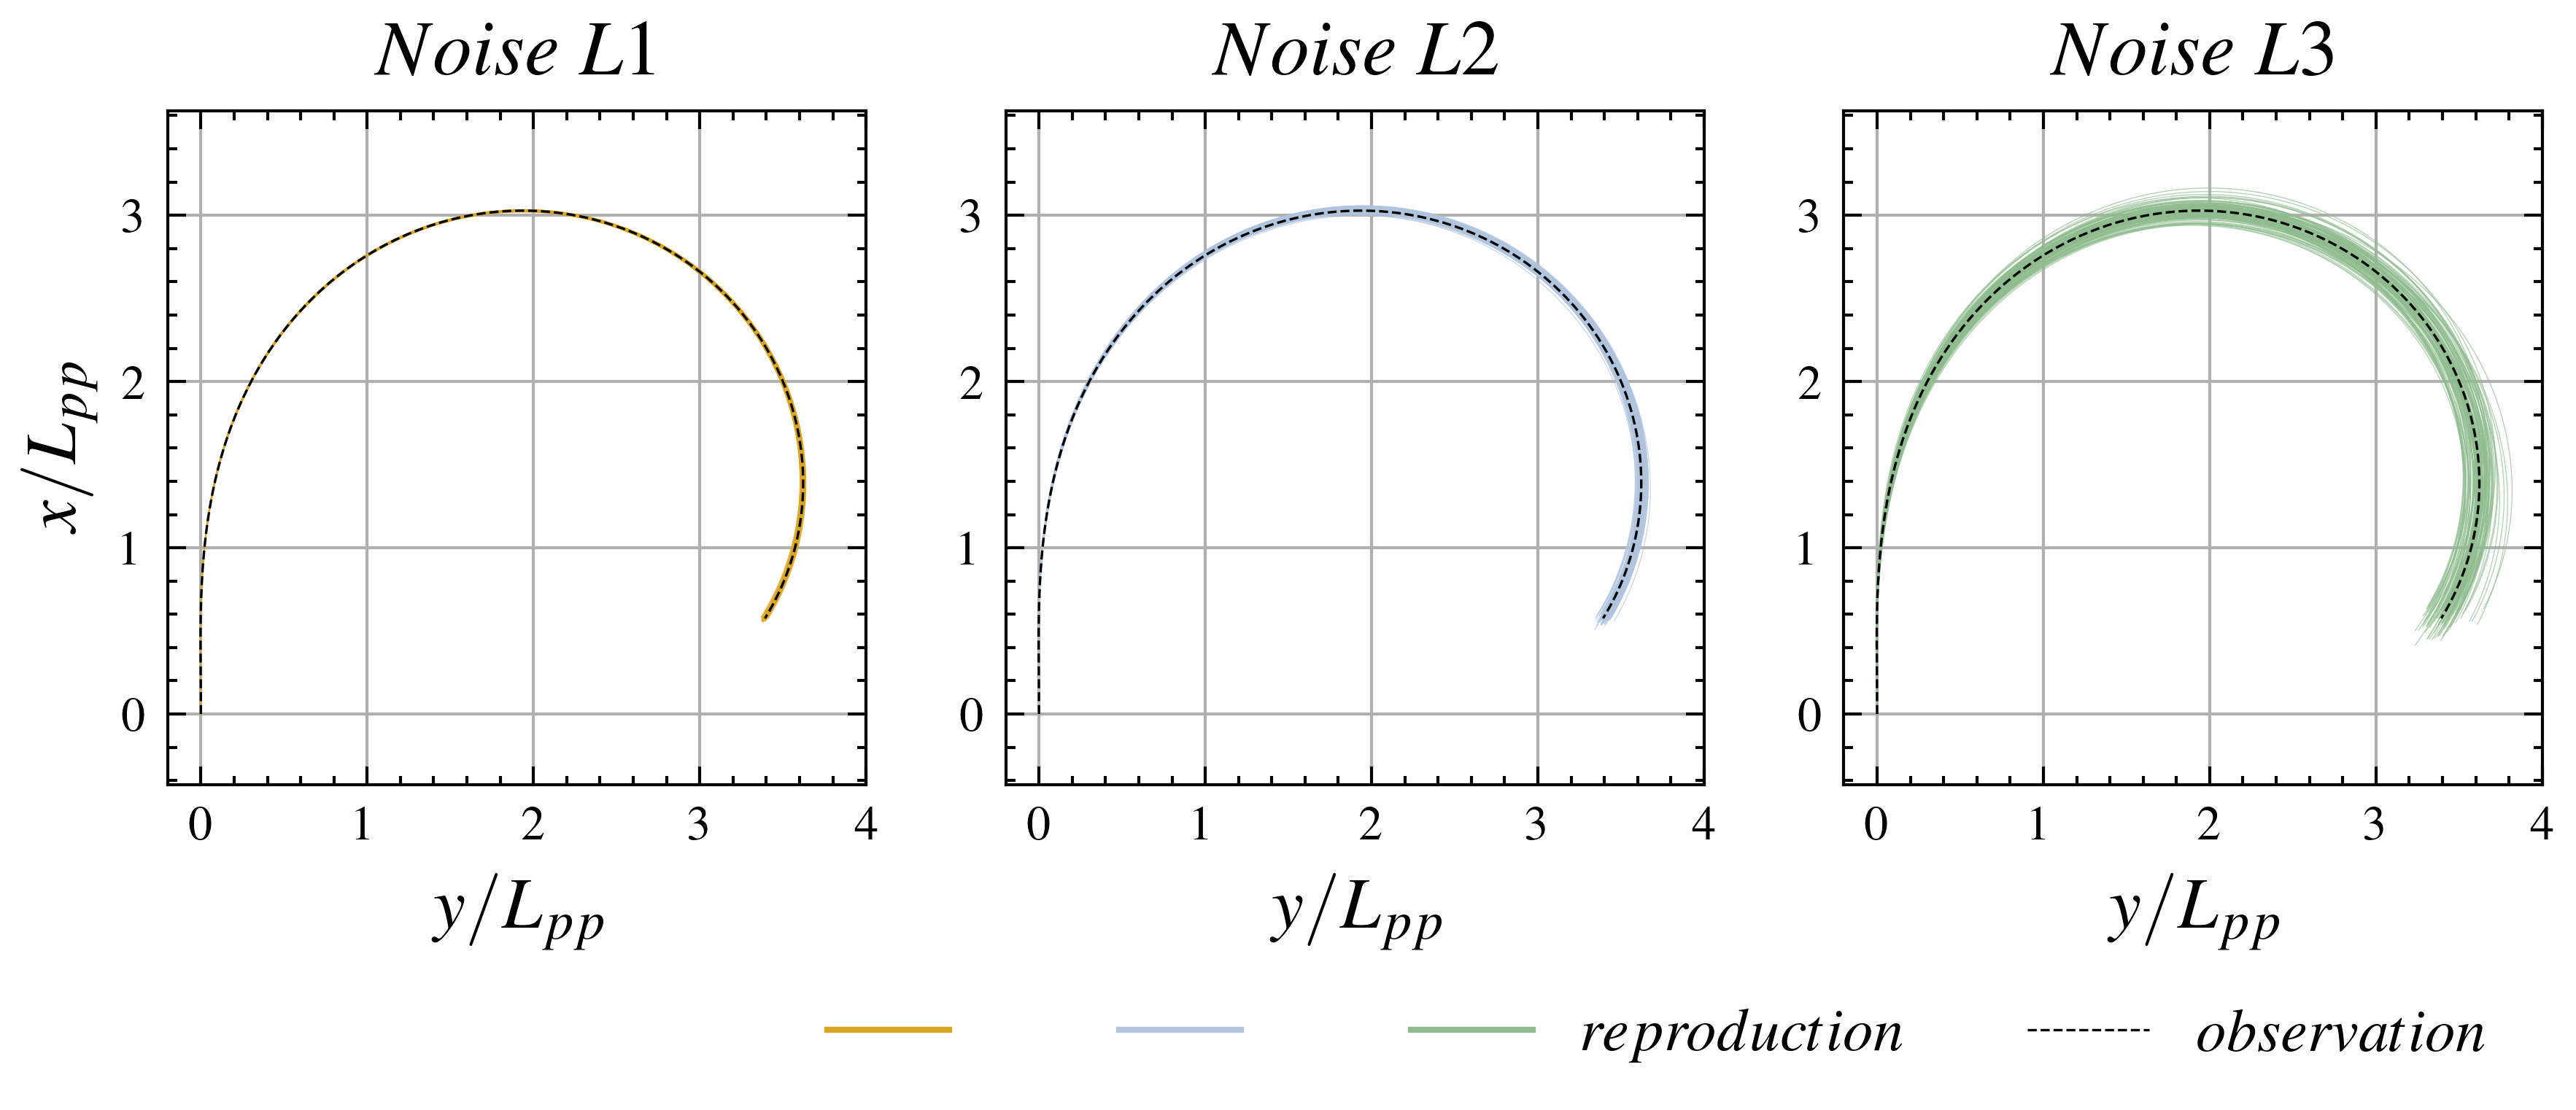

In [11]:
plt.style.use(["science", "ieee"])
fig = plt.figure(figsize=(7, 2))
ax1 = fig.add_subplot(1, 3, 1)
for i in num1:num2
    ax1.plot(results_L2_10deg.data1[i][1:sampling,"y"]/L_pp, results_L2_10deg.data1[i][1:sampling,"x"]/L_pp, "-", c="goldenrod", alpha=0.7, linewidth=0.15)
end
ax1.plot(obs10deg[1:sampling,"y"]/L_pp, obs10deg[1:sampling,"x"]/L_pp, "--", c="k", linewidth=0.4)
ax1.set_title(L"10\mathchar`-degree~turning~test", fontsize=13)
# ax1.set_title(L"U_{wind}=3.0[m/s]", fontsize=13)
ax1.set_title(L"Noise~L1", fontsize=13)
ax1.set_ylabel(L"x/L_{pp}", fontsize=12)
ax1.set_xlabel(L"y/L_{pp}", fontsize=12)
ax1.axis("equal")
ax1.set_xticks([0,1,2,3,4,5,6])
ax1.set_yticks([0,1,2,3,4,5])
ax1.set_xlim(-0.2, 6.0)
ax1.set_ylim(-1.2, 5.0)
ax1.set_xlim(-0.2, 4.0)
ax1.set_ylim(-0.5, 3.7)
ax1.grid()

ax2 = fig.add_subplot(1, 3, 2)
for i in num1:num2
    ax2.plot(results_L2_20deg.data5[i][1:sampling,"y"]/L_pp, results_L2_20deg.data5[i][1:sampling,"x"]/L_pp, "-", c="lightsteelblue", alpha=0.7, linewidth=0.15)
end
ax2.plot(obs20deg[1:sampling,"y"]/L_pp, obs20deg[1:sampling,"x"]/L_pp, "--", c="k", linewidth=0.4)
ax2.set_title(L"20\mathchar`-degree~turning~test", fontsize=13)
# ax2.set_title(L"U_{wind}=5.0[m/s]", fontsize=13)
ax2.set_title(L"Noise~L2", fontsize=13)
ax2.set_xlabel(L"y/L_{pp}", fontsize=12)
ax2.axis("equal")
ax2.set_xticks([0,1,2,3,4,5,6])
ax2.set_yticks([0,1,2,3,4,5])
ax2.set_xlim(-0.2, 4.0)
ax2.set_ylim(-0.5, 3.7)
ax2.grid()

ax3 = fig.add_subplot(1, 3, 3)
for i in num1:num2
    ax3.plot(results_L2_35deg.data9[i][1:sampling,"y"]/L_pp, results_L2_35deg.data9[i][1:sampling,"x"]/L_pp, "-", c="darkseagreen", alpha=0.7, linewidth=0.15)
end
ax3.plot([],[], "-", label=L" ",  c="goldenrod", linewidth=1)
ax3.plot([],[], "-", label=L" ",  c="lightsteelblue", linewidth=1)
ax3.plot([],[], "-", label=L"reproduction",  c="darkseagreen", linewidth=1)
ax3.plot(obs35deg[1:sampling,"y"]/L_pp, obs35deg[1:sampling,"x"]/L_pp, "--", c="k", label=L"observation", linewidth=0.4)
ax3.set_title(L"35\mathchar`-degree~turning~test", fontsize=13)
# ax3.set_title(L"U_{wind}=7.0[m/s]", fontsize=13)
ax3.set_title(L"Noise~L3", fontsize=13)
ax3.set_xlabel(L"y/L_{pp}", fontsize=12)
ax3.axis("equal")
ax3.set_xticks([0,1,2,3,4,5,6])
ax3.set_yticks([0,1,2,3,4,5])
ax3.set_xlim(-0.2, 3.0)
ax3.set_ylim(-0.2, 3)
ax3.set_xlim(-0.2, 4.0)
ax3.set_ylim(-0.5, 3.7)
ax3.grid()
ax3.legend(bbox_to_anchor=(1.0, -0.25), fontsize=10, ncol=4)

display(fig)

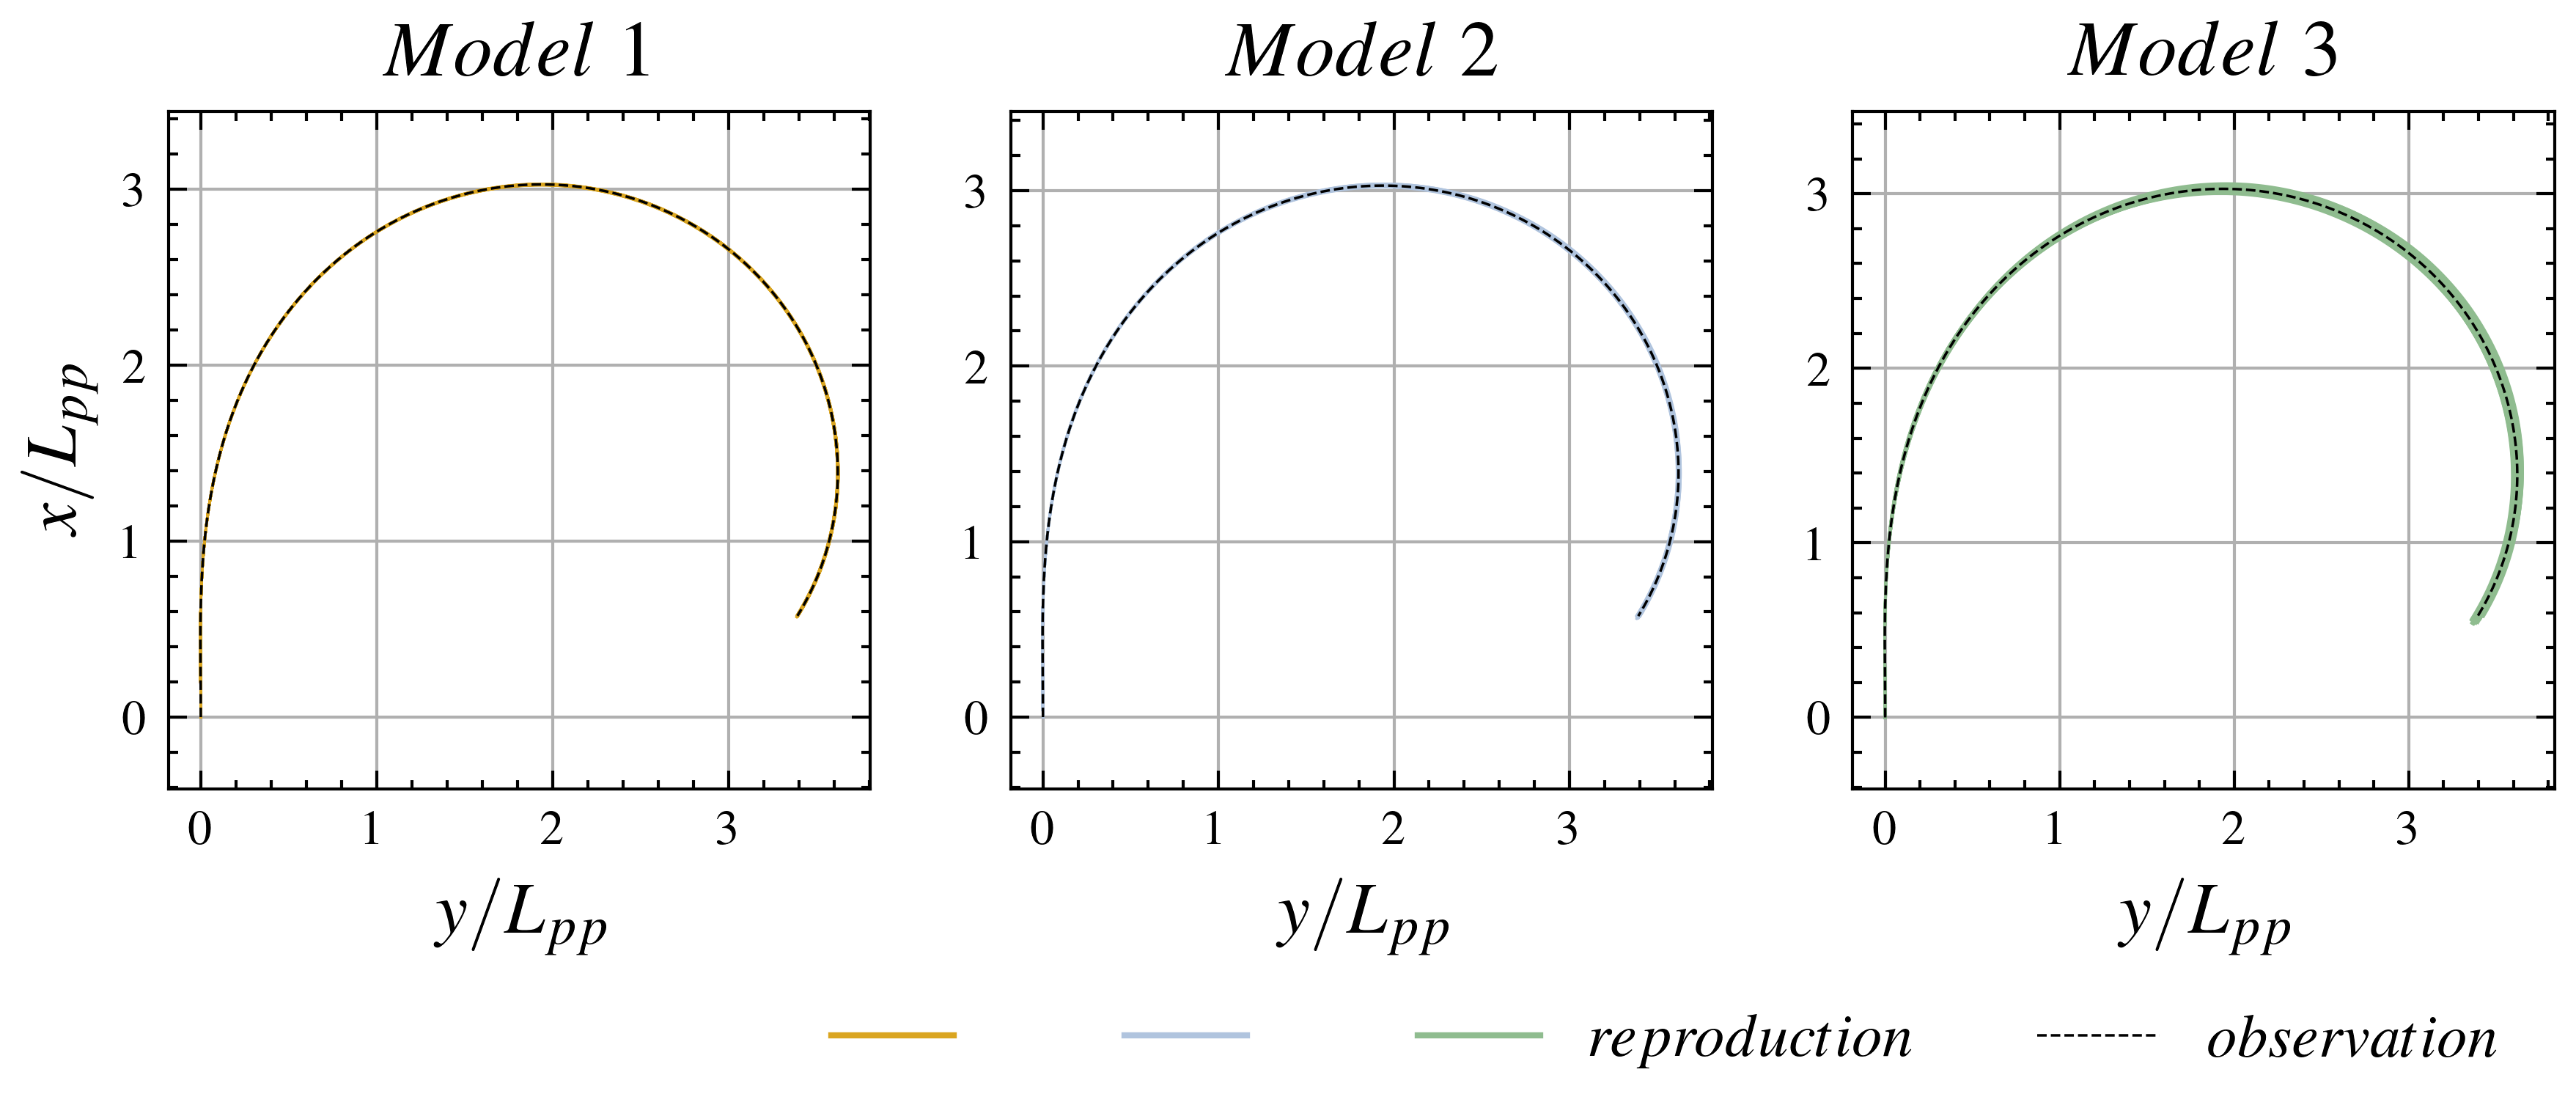

In [7]:
plt.style.use(["science", "ieee"])

fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 3, 1)
skip = 10
scale = 50
width = 0.004
alpha = 1
start = 30
# ax.quiver(obs10deg[start:skip:whole_step,"y"]/L_pp, obs10deg[start:skip:whole_step,"x"]/L_pp, obs10deg[start:skip:whole_step,"Y_wind"].*cos.(obs10deg[start:skip:whole_step,"ψ"]).+obs10deg[start:skip:whole_step,"X_wind"].*sin.(obs10deg[start:skip:whole_step,"ψ"]), .-obs10deg[start:skip:whole_step,"Y_wind"].*sin.(obs10deg[start:skip:whole_step,"ψ"])+obs10deg[start:skip:whole_step,"X_wind"].*cos.(obs10deg[start:skip:whole_step,"ψ"]), angles="xy", scale_units="xy" ,scale=scale, width=width,color="k", alpha=alpha, label="Target")
# ax.quiver(obs10deg[start:skip:whole_step,"y"]/L_pp, obs10deg[start:skip:whole_step,"x"]/L_pp, F10deg[start:skip:whole_step,"y_F_earth_median"], F10deg[start:skip:whole_step,"x_F_earth_median"], angles="xy", scale_units="xy" ,scale=scale, width=width,color="goldenrod", alpha=1, label="MPC")
for i in num1:num2
    ax.plot(results_L2_10deg_r.data2[i][1:sampling,"y"]/L_pp, results_L2_10deg_r.data2[i][1:sampling,"x"]/L_pp, "-", alpha=1.0,  c="goldenrod", linewidth=0.41)
end
ax.plot(obs10deg[1:sampling,"y"]/L_pp, obs10deg[1:sampling,"x"]/L_pp, "--", c="k", linewidth=0.42)
ax.set_title(L"10\mathchar`-degree~turning~test", fontsize=13)
ax.set_title(L"Model~1", fontsize=13)
ax.set_ylabel(L"x/L_{pp}", fontsize=12)
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
# ax.set_xlim(-0.3, 6.2)
# ax.set_ylim(-1.2,5)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_yticks([0,1,2,3,4,5])

ax.axis("equal")
# ax.set_ylim(-0.5,6)
# ax.set_xlim(-0.5,6)
ax.grid()

ax = fig.add_subplot(1, 3, 2)
# ax.quiver(obs20deg[start:skip:whole_step,"y"]/L_pp, obs20deg[start:skip:whole_step,"x"]/L_pp, obs20deg[start:skip:whole_step,"Y_wind"].*cos.(obs20deg[start:skip:whole_step,"ψ"]).+obs20deg[start:skip:whole_step,"X_wind"].*sin.(obs20deg[start:skip:whole_step,"ψ"]), .-obs20deg[start:skip:whole_step,"Y_wind"].*sin.(obs20deg[start:skip:whole_step,"ψ"])+obs20deg[start:skip:whole_step,"X_wind"].*cos.(obs20deg[start:skip:whole_step,"ψ"]), angles="xy", scale_units="xy" ,scale=scale, width=width,color="k", alpha=alpha, label="Target")
# ax.quiver(obs20deg[start:skip:whole_step,"y"]/L_pp, obs20deg[start:skip:whole_step,"x"]/L_pp, F20deg[start:skip:whole_step,"y_F_earth_median"], F20deg[start:skip:whole_step,"x_F_earth_median"], angles="xy", scale_units="xy" ,scale=scale, width=width,color="lightsteelblue", alpha=1, label="MPC")
for i in num1:num2
    ax.plot(results_L2_20deg_r.data6[i][1:sampling,"y"]/L_pp, results_L2_20deg_r.data6[i][1:sampling,"x"]/L_pp, "-", alpha=1.0,  c="lightsteelblue", linewidth=0.41)
end
ax.plot(obs20deg[1:sampling,"y"]/L_pp, obs20deg[1:sampling,"x"]/L_pp, "--", c="k", linewidth=0.42)
ax.set_title(L"20\mathchar`-degree~turning~test", fontsize=13)
ax.set_title(L"Model~2", fontsize=13)
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
# ax.set_xlim(-0.3, 6.2)
# ax.set_ylim(-1.2,5)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_yticks([0,1,2,3,4,5])
ax.axis("equal")
# ax.set_ylim(-0.5,4.5)
# ax.set_xlim(-0.5,4.5)
ax.grid()

ax = fig.add_subplot(1, 3, 3)
# ax.quiver(obs35deg[start:skip:whole_step,"y"]/L_pp, obs35deg[start:skip:whole_step,"x"]/L_pp, obs35deg[start:skip:whole_step,"Y_wind"].*cos.(obs35deg[start:skip:whole_step,"ψ"]).+obs35deg[start:skip:whole_step,"X_wind"].*sin.(obs35deg[start:skip:whole_step,"ψ"]), .-obs35deg[start:skip:whole_step,"Y_wind"].*sin.(obs35deg[start:skip:whole_step,"ψ"])+obs35deg[start:skip:whole_step,"X_wind"].*cos.(obs35deg[start:skip:whole_step,"ψ"]), angles="xy", scale_units="xy" ,scale=scale, width=width,color="k", linestyle="dotted", alpha=alpha)
# ax.quiver(obs35deg[start:skip:whole_step,"y"]/L_pp, obs35deg[start:skip:whole_step,"x"]/L_pp, F35deg[start:skip:whole_step,"y_F_earth_median"], F35deg[start:skip:whole_step,"x_F_earth_median"], angles="xy", scale_units="xy" ,scale=scale, width=width,color="darkseagreen", alpha=1)
for i in num1:num2
    ax.plot(results_L2_35deg_r.data10[i][1:sampling,"y"]/L_pp, results_L2_35deg_r.data10[i][1:sampling,"x"]/L_pp, "-", alpha=1.0,  c="darkseagreen", linewidth=0.41)
end
ax.plot([],[], "-", label=L" ",  c="goldenrod", linewidth=1)
ax.plot([],[], "-", label=L" ",  c="lightsteelblue", linewidth=1)
ax.plot([],[], "-", label=L"reproduction",  c="darkseagreen", linewidth=1)
ax.plot(obs35deg[1:sampling,"y"]/L_pp, obs35deg[1:sampling,"x"]/L_pp, "--", c="k", label=L"observation",linewidth=0.42)
ax.set_title(L"35\mathchar`-degree~turning~test", fontsize=13)
ax.set_title(L"Model~3", fontsize=13)
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
# ax.set_xlim(-0.3, 6.2)
# ax.set_ylim(-1.2,5)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_yticks([0,1,2,3,4,5])
ax.axis("equal")
# ax.set_ylim(-0.5,3.5)
# ax.set_xlim(-0.5,3.5)
ax.grid()
ax.legend(bbox_to_anchor=(1.0, -0.25), fontsize=10, ncol = 4)
display(fig)

In [8]:
fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 3, 1)
for i in num1:num2
    ax.plot(results_L3_10deg.data3[i][1:sampling,"y"]/L_pp, results_L3_10deg.data3[i][1:sampling,"x"]/L_pp, "-", alpha=1.0,  c="goldenrod", linewidth=0.4)
end
ax.plot(obs10deg[1:sampling,"y"]/L_pp, obs10deg[1:sampling,"x"]/L_pp, "--", c="k", linewidth=0.4)
ax.set_title(L"10\mathchar`-degree~turning~test", fontsize=13)
ax.set_ylabel(L"x/L_{pp}", fontsize=12)
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
# ax.set_xlim(-0.3, 6.2)
# ax.set_ylim(-1.2,5)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_yticks([0,1,2,3,4,5])
ax.axis("equal")
ax.grid()

ax = fig.add_subplot(1, 3, 2)
for i in num1:num2
    ax.plot(results_L3_20deg.data7[i][1:sampling,"y"]/L_pp, results_L3_20deg.data7[i][1:sampling,"x"]/L_pp, "-", alpha=1.0,  c="lightsteelblue", linewidth=0.4)
end
ax.plot(obs20deg[1:sampling,"y"]/L_pp, obs20deg[1:sampling,"x"]/L_pp, "--", c="k", linewidth=0.4)
ax.set_title(L"20\mathchar`-degree~turning~test", fontsize=13)
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
# ax.set_xlim(-0.3, 6.2)
# ax.set_ylim(-1.2,5)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_yticks([0,1,2,3,4,5])
ax.axis("equal")
ax.grid()

ax = fig.add_subplot(1, 3, 3)
for i in num1:num2
    ax.plot(results_L3_35deg.data11[i][1:sampling,"y"]/L_pp, results_L3_35deg.data11[i][1:sampling,"x"]/L_pp, "-", alpha=1.0,  c="darkseagreen", linewidth=0.4)
end
ax.plot([],[], "-", label=L" ",  c="goldenrod", linewidth=1)
ax.plot([],[], "-", label=L" ",  c="lightsteelblue", linewidth=1)
ax.plot([],[], "-", label=L"simulation",  c="darkseagreen", linewidth=1)
ax.plot(obs35deg[1:sampling,"y"]/L_pp, obs35deg[1:sampling,"x"]/L_pp, "--", c="k", label="observation", linewidth=0.4)
ax.set_title(L"35\mathchar`-degree~turning~test", fontsize=13)
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
# ax.set_xlim(-0.3, 6.2)
# ax.set_ylim(-1.2,5)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_yticks([0,1,2,3,4,5])
ax.axis("equal")
ax.grid()
ax.legend(bbox_to_anchor=(1.0, -0.25), fontsize=10, ncol=4)
display(fig)

KeyError: KeyError: key 100 not found

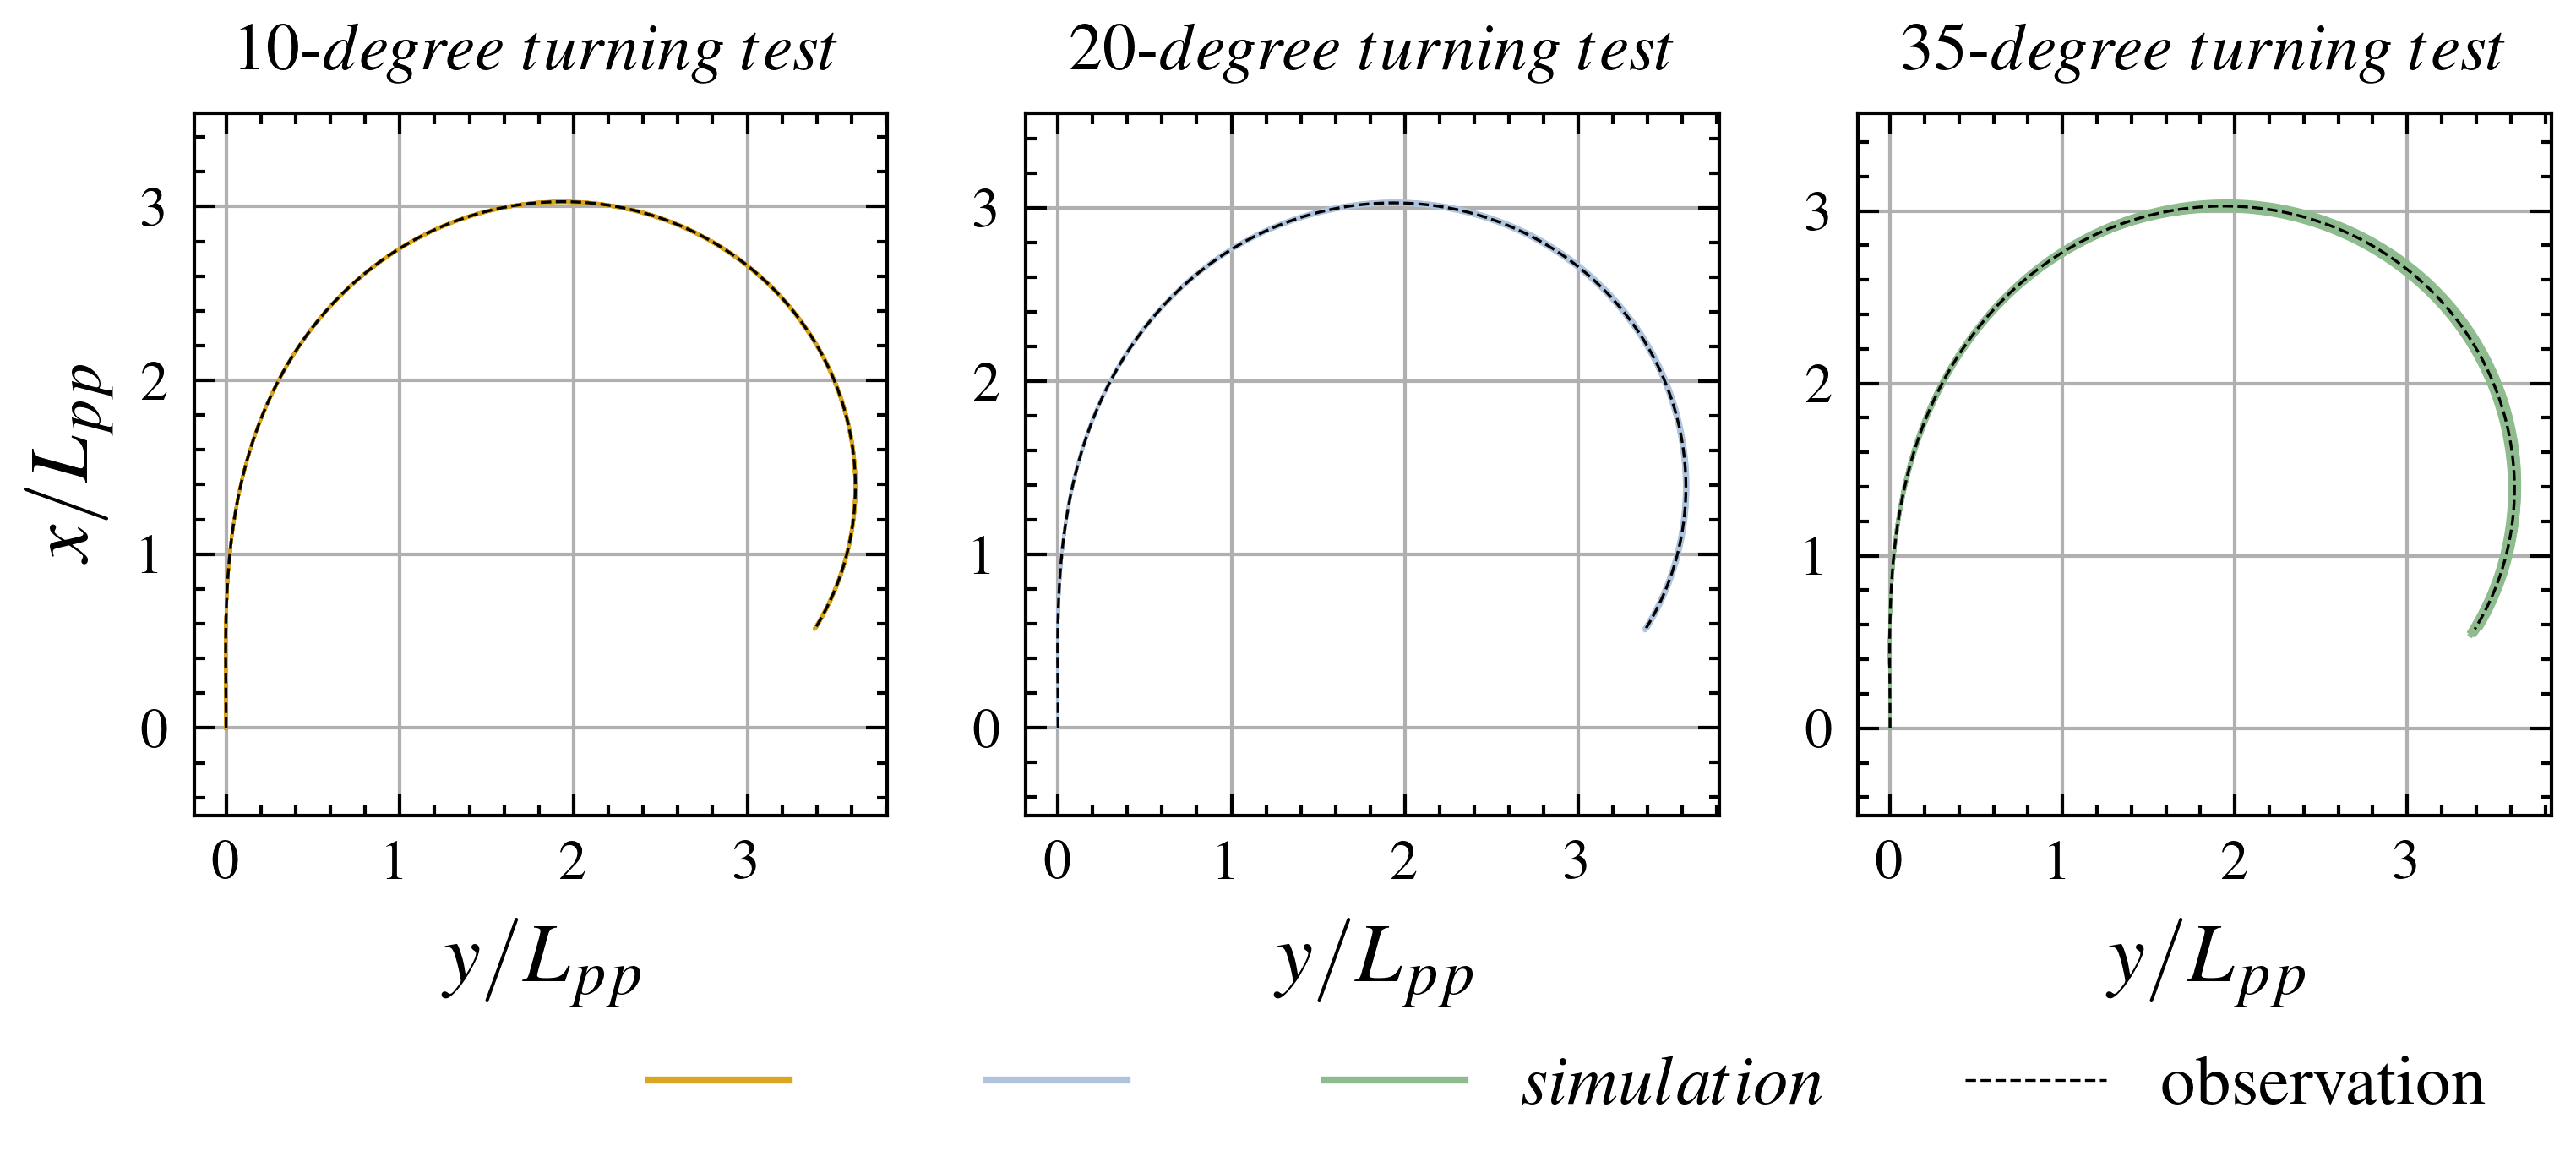

KeyError: KeyError: key 100 not found

In [9]:
plt.style.use(["science", "ieee"])

fig = plt.figure(figsize=(6, 1.8))
ax = fig.add_subplot(1, 3, 1)
for i in num1:num2
    ax.plot(results_L2_10deg_r.data2[i][1:sampling,"y"]/L_pp, results_L2_10deg_r.data2[i][1:sampling,"x"]/L_pp, "-", alpha=1.0,  c="goldenrod", linewidth=0.4)
end
ax.plot(obs10deg[1:sampling,"y"]/L_pp, obs10deg[1:sampling,"x"]/L_pp, "--", c="k", linewidth=0.4)
ax.set_title(L"10\mathchar`-degree~turning~test")
ax.set_ylabel(L"x/L_{pp}", fontsize=12)
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
# ax.set_xlim(-0.3, 6.2)
# ax.set_ylim(-1.2,5)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_yticks([0,1,2,3,4,5])
ax.axis("equal")
ax.grid()

ax = fig.add_subplot(1, 3, 2)
for i in num1:num2
    ax.plot(results_L2_20deg_r.data6[i][1:sampling,"y"]/L_pp, results_L2_20deg_r.data6[i][1:sampling,"x"]/L_pp, "-", alpha=1.0,  c="lightsteelblue", linewidth=0.4)
end
ax.plot(obs20deg[1:sampling,"y"]/L_pp, obs20deg[1:sampling,"x"]/L_pp, "--", c="k", linewidth=0.4)
ax.set_title(L"20\mathchar`-degree~turning~test")
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
# ax.set_xlim(-0.3, 6.2)
# ax.set_ylim(-1.2,5)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_yticks([0,1,2,3,4,5])
ax.axis("equal")
ax.grid()

ax = fig.add_subplot(1, 3, 3)
for i in num1:num2
    ax.plot(results_L2_35deg_r.data10[i][1:sampling,"y"]/L_pp, results_L2_35deg_r.data10[i][1:sampling,"x"]/L_pp, "-", alpha=1.0,  c="darkseagreen", linewidth=0.4)
end
ax.plot([],[], "-", label=L" ",  c="goldenrod", linewidth=1)
ax.plot([],[], "-", label=L" ",  c="lightsteelblue", linewidth=1)
ax.plot([],[], "-", label=L"simulation",  c="darkseagreen", linewidth=1)
ax.plot(obs35deg[1:sampling,"y"]/L_pp, obs35deg[1:sampling,"x"]/L_pp, "--", label="observation", c="k", linewidth=0.4)
ax.set_title(L"35\mathchar`-degree~turning~test")
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
# ax.set_xlim(-0.3, 6.2)
# ax.set_ylim(-1.2,5)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_yticks([0,1,2,3,4,5])
ax.axis("equal")
ax.legend(bbox_to_anchor=(1.0, -0.25), fontsize=10, ncol=4)
ax.grid()
display(fig)



fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 3, 1)
for i in num1:num2
    ax.plot(results_L3_10deg_r.data4[i][1:sampling,"y"]/L_pp, results_L3_10deg_r.data4[i][1:sampling,"x"]/L_pp, "-", alpha=1.0,  c="goldenrod", linewidth=0.4)
end
ax.plot(obs10deg[1:sampling,"y"]/L_pp, obs10deg[1:sampling,"x"]/L_pp, "--", c="k", linewidth=0.4)
ax.set_title(L"10\mathchar`-degree~turning~test")
ax.set_ylabel(L"x/L_{pp}", fontsize=12)
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_yticks([0,1,2,3,4,5])
ax.axis("equal")
ax.grid()

ax = fig.add_subplot(1, 3, 2)
for i in num1:num2
    ax.plot(results_L3_20deg_r.data8[i][1:sampling,"y"]/L_pp, results_L3_20deg_r.data8[i][1:sampling,"x"]/L_pp, "-", alpha=1.0,  c="lightsteelblue", linewidth=0.4)
end
ax.plot(obs20deg[1:sampling,"y"]/L_pp, obs20deg[1:sampling,"x"]/L_pp, "--", c="k", linewidth=0.4)
ax.set_title(L"20\mathchar`-degree~turning~test")
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_yticks([0,1,2,3,4,5])
ax.axis("equal")
ax.grid()

ax = fig.add_subplot(1, 3, 3)
for i in num1:num2
    ax.plot(results_L3_35deg_r.data12[i][1:sampling,"y"]/L_pp, results_L3_35deg_r.data12[i][1:sampling,"x"]/L_pp, "-", alpha=1.0,  c="darkseagreen", linewidth=0.4)
end
ax.plot([],[], "-", label=L" ",  c="goldenrod", linewidth=1)
ax.plot([],[], "-", label=L" ",  c="lightsteelblue", linewidth=1)
ax.plot([],[], "-", label=L"simulation",  c="darkseagreen", linewidth=1)
ax.plot(obs35deg[1:sampling,"y"]/L_pp, obs35deg[1:sampling,"x"]/L_pp, "--", label="observation", c="k", linewidth=0.4)
ax.set_title(L"35\mathchar`-degree~turning~test")
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_yticks([0,1,2,3,4,5])
ax.axis("equal")
ax.legend(bbox_to_anchor=(1.0, -0.25), fontsize=10, ncol=4)
ax.grid()
display(fig)

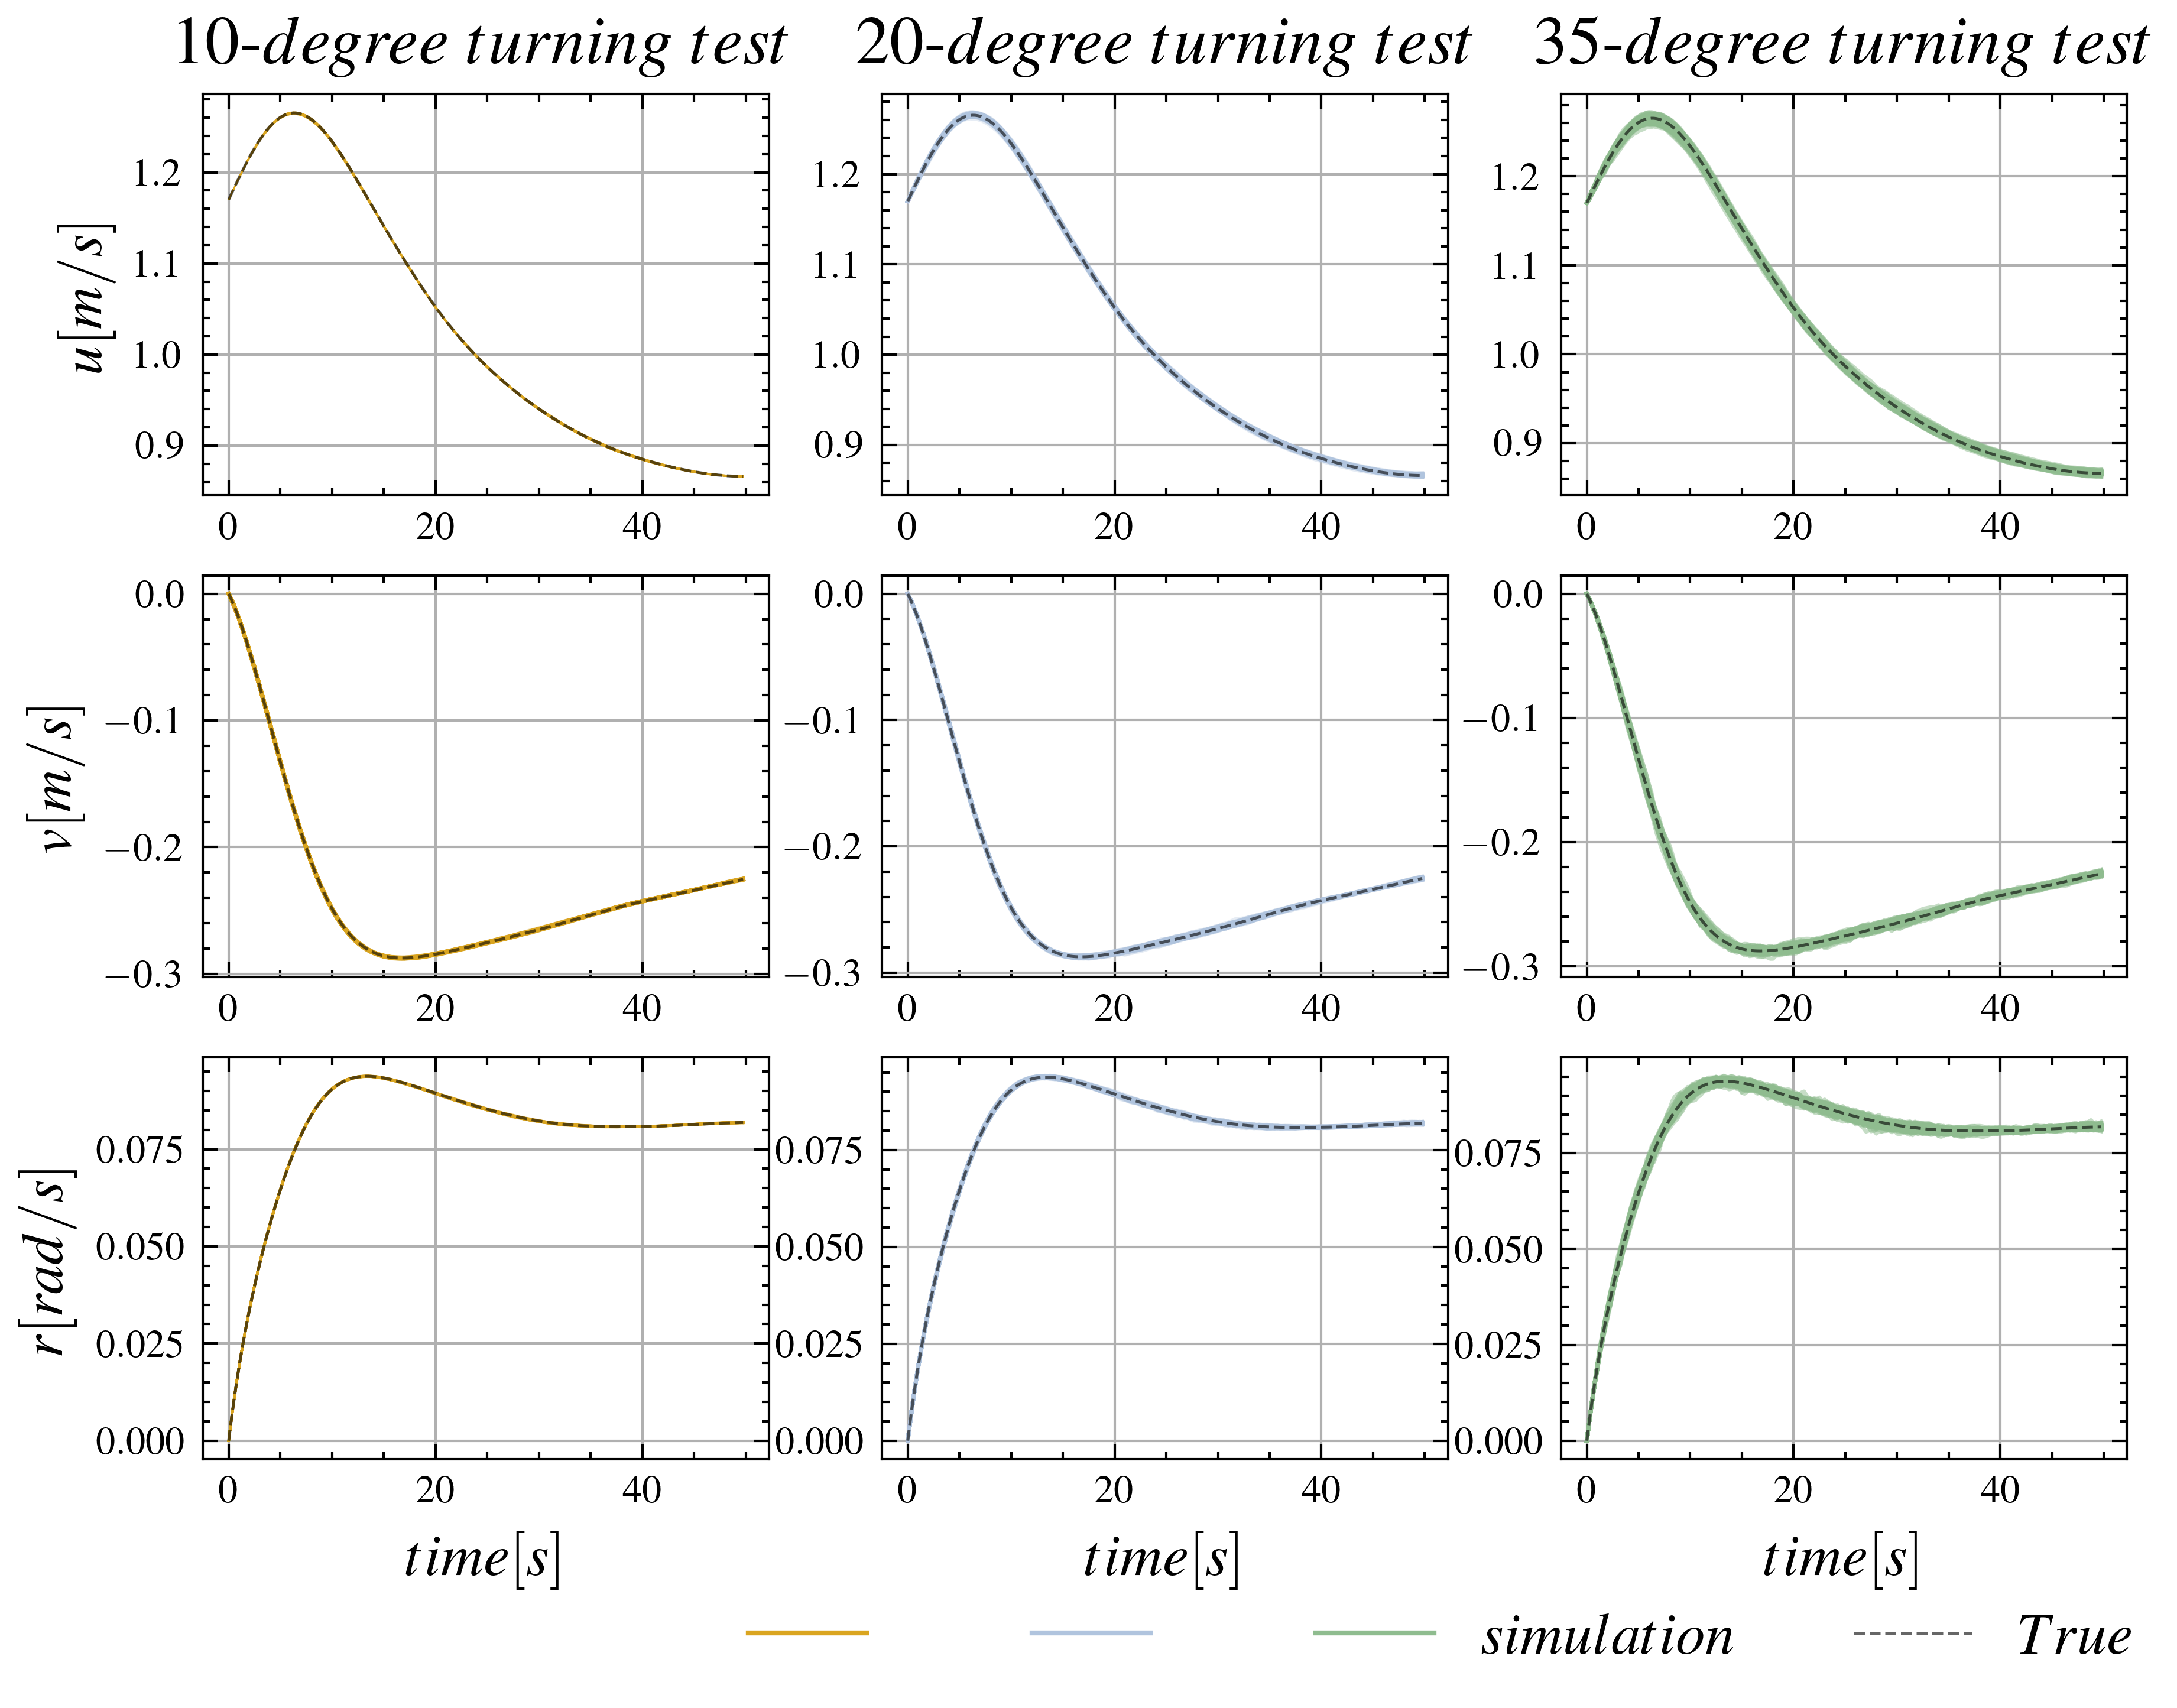

In [10]:
plt.style.use(["science", "ieee"])
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(3, 3, 1)
ax.set_title(L"10\mathchar`-degree~turning~test", fontsize=14)

for i in num1:num2
    ax.plot(results_L2_10deg_r.data2[i][1:sampling,"time"], results_L2_10deg_r.data2[i][1:sampling,"u"], "-", alpha=1.0,  c="goldenrod", linewidth=0.2)
end
ax.plot(obs10deg[1:sampling,"time"], obs10deg[1:sampling,"u"], "--", c="k", linewidth=0.6, alpha=0.6)
ax.set_ylabel(L"$u [m/s]$", fontsize=12)
ax.grid()

ax = fig.add_subplot(3, 3, 4)

for i in num1:num2
    ax.plot(results_L2_10deg_r.data2[i][1:sampling,"time"], results_L2_10deg_r.data2[i][1:sampling,"v"], "-", alpha=0.3,  c="goldenrod", linewidth=0.8)
end
ax.plot(obs10deg[1:sampling,"time"], obs10deg[1:sampling,"v"],  "--", c="k", linewidth=0.6, alpha=0.6)
ax.set_ylabel(L"$v [m/s]$", fontsize=12)
ax.grid()

ax = fig.add_subplot(3, 3, 7)

for i in num1:num2
    ax.plot(results_L2_10deg_r.data2[i][1:sampling,"time"], results_L2_10deg_r.data2[i][1:sampling,"r"], "-", alpha=0.3,  c="goldenrod", linewidth=0.5)
end
ax.plot(obs10deg[1:sampling,"time"], obs10deg[1:sampling,"r"],  "--", c="k", linewidth=0.6, alpha=0.6)
ax.set_ylabel(L"$r [rad/s]$", fontsize=12)
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()

ax = fig.add_subplot(3, 3, 2)
ax.set_title(L"20\mathchar`-degree~turning~test", fontsize=14)

for i in num1:num2
    ax.plot(results_L2_20deg_r.data6[i][1:sampling,"time"], results_L2_20deg_r.data6[i][1:sampling,"u"], "-", alpha=0.3,  c="lightsteelblue", linewidth=0.8)
end
ax.plot(obs20deg[1:sampling,"time"], obs20deg[1:sampling,"u"], "--", c="k", linewidth=0.6, alpha=0.6)
ax.grid()

ax = fig.add_subplot(3, 3, 5)

for i in num1:num2
    ax.plot(results_L2_20deg_r.data6[i][1:sampling,"time"], results_L2_20deg_r.data6[i][1:sampling,"v"], "-", alpha=0.3,  c="lightsteelblue", linewidth=0.8)
end
ax.plot(obs20deg[1:sampling,"time"], obs20deg[1:sampling,"v"],  "--", c="k", linewidth=0.6, alpha=0.6)
ax.grid()

ax = fig.add_subplot(3, 3, 8)

for i in num1:num2
    ax.plot(results_L2_20deg_r.data6[i][1:sampling,"time"], results_L2_20deg_r.data6[i][1:sampling,"r"], "-", alpha=0.3,  c="lightsteelblue", linewidth=0.8)
end
ax.plot(obs20deg[1:sampling,"time"], obs20deg[1:sampling,"r"],  "--", c="k", linewidth=0.6, alpha=0.6)
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()


ax = fig.add_subplot(3, 3, 3)
ax.set_title(L"35\mathchar`-degree~turning~test", fontsize=14)

for i in num1:num2
    ax.plot(results_L2_35deg_r.data10[i][1:sampling,"time"], results_L2_35deg_r.data10[i][1:sampling,"u"], "-", alpha=0.5,  c="darkseagreen", linewidth=0.8)
end
ax.plot(obs35deg[1:sampling,"time"], obs35deg[1:sampling,"u"], "--", c="k", linewidth=0.6, alpha=0.6)
ax.grid()

ax = fig.add_subplot(3, 3, 6)

for i in num1:num2
    ax.plot(results_L2_35deg_r.data10[i][1:sampling,"time"], results_L2_35deg_r.data10[i][1:sampling,"v"], "-", alpha=0.5,  c="darkseagreen", linewidth=0.8)
end
ax.plot(obs35deg[1:sampling,"time"], obs35deg[1:sampling,"v"],  "--", c="k", linewidth=0.6, alpha=0.6)
ax.grid()

ax = fig.add_subplot(3, 3, 9)
ax.plot([],[], "-", label=L" ",  c="goldenrod", linewidth=1)
ax.plot([],[], "-", label=L" ",  c="lightsteelblue", linewidth=1)
ax.plot([],[], "-", label=L"simulation",  c="darkseagreen", linewidth=1)

for i in num1:num2
    ax.plot(results_L2_35deg_r.data10[i][1:sampling,"time"], results_L2_35deg_r.data10[i][1:sampling,"r"], "-", alpha=0.5, c="darkseagreen", linewidth=0.8)
end
ax.plot(obs35deg[1:sampling,"time"], obs35deg[1:sampling,"r"], label=L"True",  "--", c="k", linewidth=0.6, alpha=0.6)
ax.legend(bbox_to_anchor=(1.11, -0.25), fontsize=12, ncol=4)
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()

display(fig)